In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset # Network Common Data Form
import sys
import xarray as xr
from datetime import date
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import os
import xesmf as xe
import cm_xml_to_matplotlib as cm

# Import data below
%run MapPlotImportData.ipynb

In [2]:
# ************************************************************************************************
# *************************** USER INPUTS ARE REQUIRED IN THIS CELL ******************************
# ************************************************************************************************


#### Select the date to be analyzed as a value representing the number of days since 2009-09-01 ####
dayOfTheSeason = 175 # For reference: 174 is February 22 and 122 is January 1

#### Select the number of days to be time averaged ####
numDayAvg = 7

# Choose region of interest 
lats =  -20
latn =  20
lonw = -180 # *** For longitudes west of the Prime Meridian, enter a negative number ***
lone = -90  

# ************************************************************************************************

In [3]:
## Select the data within the user defined region of interest

# First, check if the user has requested data that is out of the time bounds of hindcast dataset
# If so, null all relevant variables to prevent any erroneous plots
if dayOfTheSeason+numDayAvg-1 > dataPRECT[1]['time'][-1] or dayOfTheSeason < dataPRECT[1]['time'][0]:
    prectSel=None; vbotSel=None; ubotSel=None; vbotObsSel=None; ubotObsSel=None; prectObsSel=None
    prectPlot=None; vbotPlot=None; ubotPlot=None; VbotObsPlot=None; ubotObsPlot=None; prectObsPlot=None
    sys.exit("The user is attempting to access data that is outside of the time bounds of the hindcast dataset")

# Select the data within the region of interest
prectSel = [None] * len(dataPRECT)
vbotSel  = [None] * len(dataVBOT)
ubotSel  = [None] * len(dataUBOT)

# Iterate through each hindcast day to select the data in the region of interest
# The iteration starts at 1 to agree with the indexing convention of the hindcast days (starting with 1)
for ii in range(1,len(dataPRECT)): 
    # Subtract 1 from numDayAvg since a slice will include the end point
    # Add 360 to the longitude so that it agrees with the dataset which ranges from 0 to 360
    prectSel[ii] = dataPRECT[ii].sel(time=slice(dayOfTheSeason,dayOfTheSeason+numDayAvg-1), lat=slice(lats,latn), lon=slice(lonw+360,lone+360))
    vbotSel[ ii] = dataVBOT[ ii].sel(time=slice(dayOfTheSeason,dayOfTheSeason+numDayAvg-1), lat=slice(lats,latn), lon=slice(lonw+360,lone+360))
    ubotSel[ ii] = dataUBOT[ ii].sel(time=slice(dayOfTheSeason,dayOfTheSeason+numDayAvg-1), lat=slice(lats,latn), lon=slice(lonw+360,lone+360))

# Note that the latitude slice is from north to south to match the wind obs convention. Also, a conversion is required for time
vbotObsSel = dataVBOTObs.sel(time=slice( (dayOfTheSeason+40055)*24+9, (dayOfTheSeason+40055+numDayAvg-1)*24+9), 
                             latitude=slice(latn,lats), longitude=slice(lonw+360,lone+360))
ubotObsSel = dataUBOTObs.sel(time=slice( (dayOfTheSeason+40055)*24+9, (dayOfTheSeason+40055+numDayAvg-1)*24+9), 
                             latitude=slice(latn,lats), longitude=slice(lonw+360,lone+360))

# Add 40055 to change the reference date of dayOfTheSeason from 2009-09-01 to 1900-01-01
prectObsSel = dataPRECTObs['pr'].sel(time=slice(dayOfTheSeason+40055, dayOfTheSeason+numDayAvg-1+40055), lat=slice(lats,latn), lon=slice(lonw,lone))

In [4]:
# Average the data for the length of the numDayAvg specificed 

# Initialize lists for hindcast data
prectPlot = [None] * len(prectSel)
vbotPlot  = [None] * len(vbotSel)
ubotPlot  = [None] * len(ubotSel)

# Perform time average for all hindcast days
for ii in range(1, len(prectSel)):
    prectPlot[ii] = prectSel[ii].mean(dim='time')
    vbotPlot[ ii] = vbotSel[ ii].mean(dim='time')
    ubotPlot[ ii] = ubotSel[ ii].mean(dim='time')

# Perform average for obs data
vbotObsPlot  = vbotObsSel.mean( dim='time')
ubotObsPlot  = ubotObsSel.mean( dim='time')
prectObsPlot = prectObsSel.mean(dim='time')

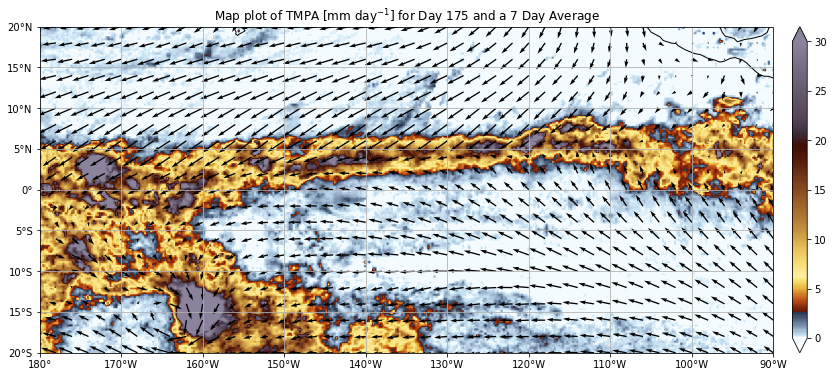

In [18]:
# Create a map plot of the observation data

##### Control plotting variables here #####

# Set maximum of colorbar [mm/day]
Vmax = 30

# Set density of arrows with n. A greater integer reduces the density of arrows 
n = 8

# Set the density of the pixels in the figure. This also affects the size of the saved figure
_dpi = 150

###########################################

# Create the figure and apply asthetic constraints
fig = plt.figure(figsize=(17, 6)) 

# Prepare colormap
mycmap = cm.make_cmap('CustomColorMap1.xml')

geo_axes = plt.axes(projection=ccrs.PlateCarree())
geo_axes.set_xticks(np.arange(lonw,lone+1,10), crs=ccrs.PlateCarree())
geo_axes.set_yticks(np.arange(lats,latn+1,5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
geo_axes.xaxis.set_major_formatter(lon_formatter)
geo_axes.yaxis.set_major_formatter(lat_formatter)
geo_axes.coastlines(resolution='110m')
geo_axes.gridlines(xlocs=np.arange(lonw,lone+1,10), ylocs=np.arange(lats,latn+1,5))
image_extent = [lonw,lone,lats,latn]

# Plot precip contour plot
IM = geo_axes.imshow(prectObsPlot, extent=image_extent, cmap=plt.get_cmap(mycmap), origin='lower', vmax=Vmax) 

# Plot wind vectors
geo_axes.quiver(ubotObsPlot['longitude'][::n],     ubotObsPlot['latitude'][::n], 
                ubotObsPlot['u10'][::n,::n], vbotObsPlot['v10'][::n,::n], transform=ccrs.PlateCarree(), width=0.0018)

# Set boundaries of plot
geo_axes.set_xlim([lonw,lone])
geo_axes.set_ylim([lats,latn])

plt.colorbar(IM, ax=geo_axes, orientation='vertical', pad=0.02, extend='both')
plt.title("Map plot of TMPA [mm day$^{-1}$] for Day "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+" Day Average")

# Save figure code
# Check if folder is there. If it is not, make the folder
dir = '/home/jlarson1/Day '+str(dayOfTheSeason)+' Analysis'
if os.path.isdir(dir) == False:
    os.mkdir(dir)

plt.savefig(dir+'/Day'+str(dayOfTheSeason)+'with'+str(numDayAvg)+'DayAvgObsMapPlot', dpi=_dpi, bbox_inches='tight')
    
plt.show()

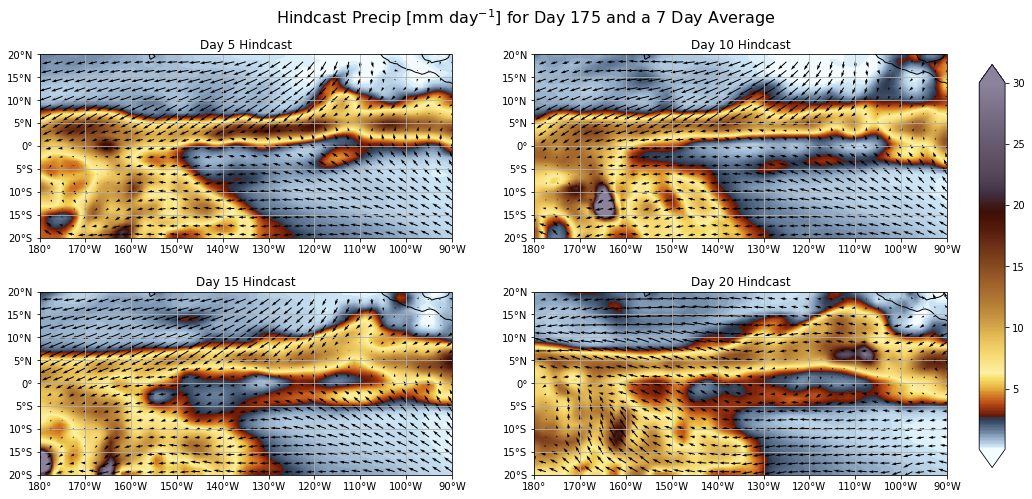

In [6]:
# Plot four subplots for each hindcast day

##### Control plotting variables here #####

# Set which days are plotted
hcastDay = [5,10,15,20]
# hcastDay = [1,2,3,4]

# Set the max value of the colorbar
Vmax = 30
# Vmax = 20

# Set the density of the wind vector arrows. A greater integer reduces the density
n = int(2)

###########################################

# Set border of precip data
image_extent = [lonw,lone,lats,latn]

# Pre-generate the subplots with a PlateCarree projection
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Prepare colormap
mycmap = cm.make_cmap('CustomColorMap1.xml')

# Iterate through the subplots
for ii, day in enumerate(hcastDay):
    
    # Plot precip in mm/day
    im = axes.flat[ii].imshow(prectPlot[day]['PRECT']*1000*86400, extent=image_extent, vmax=Vmax, origin='lower', 
                              interpolation='bilinear', cmap=plt.get_cmap(mycmap))

    # Plot horizontal wind vectors. The density of these vectors is controlled by n
    axes.flat[ii].quiver(vbotPlot[day]['lon'][::n],   vbotPlot[day]['lat'][::n], 
                         ubotPlot[day]['u'][::n,::n], vbotPlot[day]['v'][::n,::n], transform=ccrs.PlateCarree())
    
    # Set boundaries of graphs
    axes.flat[ii].set_xlim([lonw,lone])
    axes.flat[ii].set_ylim([lats,latn])
    
    # Set asthetic constraints of the plot
    axes.flat[ii].set_xticks(np.arange(lonw,lone+1,10), crs=ccrs.PlateCarree())
    axes.flat[ii].set_yticks(np.arange(lats,latn+1,5),  crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axes.flat[ii].xaxis.set_major_formatter(lon_formatter)
    axes.flat[ii].yaxis.set_major_formatter(lat_formatter)
    axes.flat[ii].coastlines(resolution='110m')
    axes.flat[ii].gridlines(xlocs=np.arange(lonw,lone+1,10), ylocs=np.arange(lats,latn+1,5)) 
    axes.flat[ii].title.set_text('Day '+str(day)+' Hindcast')
    
# The following code creates a new axes for the colorbar
fig.subplots_adjust(right=0.825)
# Add base axis for color bar. Located at 85% from left and 15% from bottom. Width is 2% of figure. Height is 70% of figure.
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7]) 
fig.colorbar(im, cax=cbar_ax, extend='both')

# Set title for the entire figure
fig.suptitle("Hindcast Precip [mm day$^{-1}$] for Day "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+" Day Average",
             size=16,y=0.95)

## Save figure code    
plt.savefig(dir+'/Day'+str(dayOfTheSeason)+'with'+str(numDayAvg)+'DayAvgHindcastMapPlot', dpi=200, bbox_inches='tight',
           transparent=True, facecolor=None, edgecolor=None, pad_inches=0)

plt.show()

In [7]:
## Increase the spatial resolution of the hindcast dataset so that it equals the resolution of obs
## Then, find the absolute error between the hindcast precip and the obs precip

# Define the region of interest for the error analysis
latsErr = -5; latnErr = -1; lonwErr = -135; loneErr = -90
 
# Define a new dataset the has the spatial grid of the obs data
ds_out = xr.Dataset({'lat': (['lat'], prectObsPlot['lat']),
                     'lon': (['lon'], prectObsPlot['lon']) })

# Initialize an empty list to hold data for each hindcast day
errAbs    = [None] * len(prectPlot)
errAbsAvg = [None] * len(prectPlot)
dr_out    = [None] * len(prectPlot)

# Iterate through each hindcast day. Here "data" is the hindcast precipitation dataSet
for ii, data in enumerate(prectPlot):
    # Skip the zero index as it is empty
    if ii==0: continue
        
    # Create a dataArray out of the dataset
    dr = data['PRECT']
    # Create a regridder function that will convert a dataArray with the resolution of the hindcasts to the resolution of the obs
    # Do this using a bilinear interpolation. Reusing the weights decreases computation time
    regridder = xe.Regridder(data['PRECT'], ds_out, 'bilinear', reuse_weights=True)
    # Regrid the precipitation dataArray
    dr_out[ii] = regridder(dr)
    # Calculate the difference between the hindcast precip and the obs precip
    errAbs[ii] = (dr_out[ii]*1000*86400) - prectObsPlot
    
    # Select the region that sees the highest amount of dITCZ bias
    errAbsSel = errAbs[ii].sel(lon=slice(lonwErr,loneErr), lat=slice(latsErr,latnErr))
    # Take a spatial average over the aforementinoed region. Assign this to a list where each index is a hindcast day
    errAbsAvg[ii] = errAbsSel.mean().values

Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc
Reuse existing file: bilinear_42x73_160x360.nc


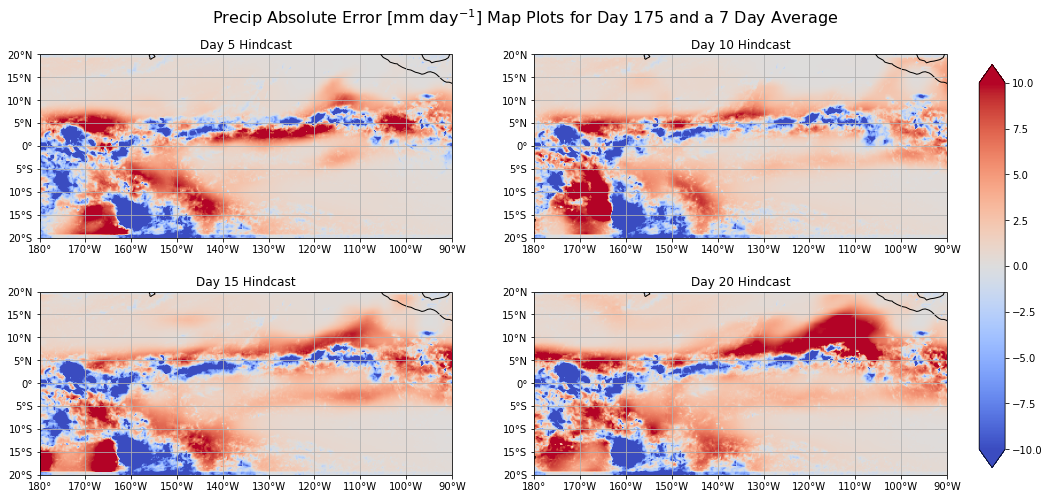

In [8]:
# Plot the precip error map plots for four hindcast days

##### Control plotting variables here #####

# Set which days are plotted
hcastDay = [5,10,15,20]
# hcastDay = [1,2,3,4]

# Set the max and min values of the colorbar
Vmax = 10
Vmin = -10

###########################################

# Set border of precip data
image_extent = [lonw,lone,lats,latn]

# Pre-generate the subplots with a PlateCarree projection
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Iterate through the subplots
for ii, day in enumerate(hcastDay):
    # Plot precip in mm/day
    im = axes.flat[ii].imshow(errAbs[day], extent=image_extent, cmap='coolwarm', vmax=Vmax, vmin=Vmin, origin='lower')

    # Set boundaries of graphs
    axes.flat[ii].set_xlim([lonw,lone])
    axes.flat[ii].set_ylim([lats,latn])
    
    # Set asthetic constraints of the plot
    axes.flat[ii].set_xticks(np.arange(lonw,lone+1,10), crs=ccrs.PlateCarree())
    axes.flat[ii].set_yticks(np.arange(lats,latn+1,5),  crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axes.flat[ii].xaxis.set_major_formatter(lon_formatter)
    axes.flat[ii].yaxis.set_major_formatter(lat_formatter)
    axes.flat[ii].coastlines(resolution='110m')
    axes.flat[ii].gridlines(xlocs=np.arange(lonw,lone+1,10), ylocs=np.arange(lats,latn+1,5)) 
    axes.flat[ii].title.set_text('Day '+str(day)+' Hindcast')

    
# The following code creates a new axes for the colorbar
fig.subplots_adjust(right=0.825)
# Add base axis for color bar. Located at 85% from left and 15% from bottom. Width is 2% of figure. Height is 70% of figure.
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7]) 
fig.colorbar(im, cax=cbar_ax, extend='both')

# Set title for the entire figure
fig.suptitle("Precip Absolute Error [mm day$^{-1}$] Map Plots for Day "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+" Day Average",
             size=16,y=0.95)

## Save figure code    
plt.savefig(dir+'/Day'+str(dayOfTheSeason)+'with'+str(numDayAvg)+'DayAvgPrecipErrorMapPlot', dpi=_dpi)

plt.show()

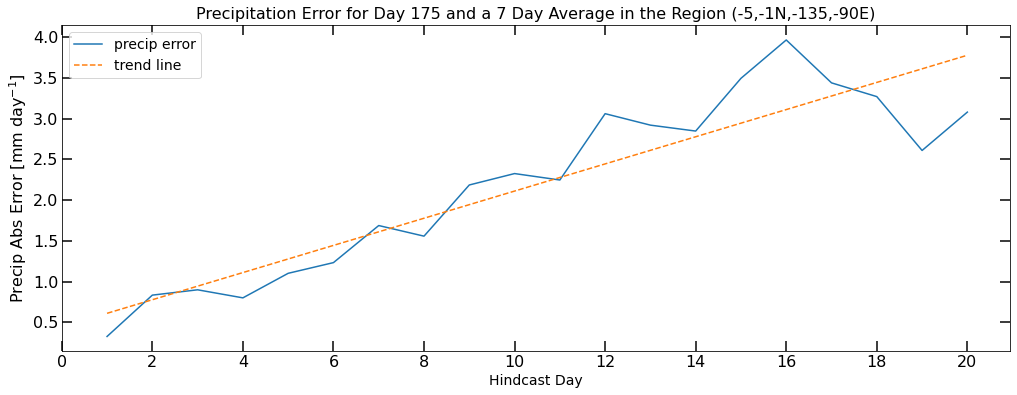

In [9]:
# Plot the dITCZ precip bias over lead time

# First, calculate the trend line of the data
hindcastDays = np.arange(1,21)
z = np.polyfit(hindcastDays, errAbsAvg[1:21], 1)
p = np.poly1d(z)
trend = p[1]*hindcastDays + p[0]

fig, ax = plt.subplots(figsize=(17,6))
plt.plot(errAbsAvg, label='precip error')
plt.plot(hindcastDays, trend, '--', label='trend line')
plt.tick_params(axis='both', which='major', length=10, width=1.5, direction='in', labelsize=16, right='True', top='True')
plt.tick_params(axis='both', which='minor', length= 5, width=1.0, direction='in', labelsize=16, right='True', top='True')
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.xticks(np.arange(0,len(errAbsAvg),2))
plt.xlabel('Hindcast Day', fontsize=14)
plt.ylabel('Precip Abs Error [mm day$^{-1}$]', fontsize=16)
plt.title('Precipitation Error for Day '+str(dayOfTheSeason)+' and a '+str(numDayAvg)+' Day Average in the Region ('+
          str(latsErr)+','+str(latnErr)+'N,'+str(lonwErr)+','+str(loneErr)+'E)', fontsize=16, wrap=True)
plt.legend(loc='upper left', prop={'size': 14})

plt.savefig(dir+'/Day'+str(dayOfTheSeason)+'with'+str(numDayAvg)+'DayAvgdITCZerror')
plt.show()